In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.


# Sequence Tagging

Sequence tagging (or sequence labeling) involves classifying words or sequences of words as representing some category or concept of interest.  One example of sequence tagging Named Entity Recognition (NER), where we classify words or sequences of words that represent some entity such as a person, organization, or location.  In this tutorial, we will show how to use *ktrain* to perform sequence tagging in four simple steps.

## STEP 1: Load the Data

The `entities_from_csv` function can be used to load tagged sentences from a CSV file (or similar formats such as tab-delimited).  We assume the CSV has at three columns where each row represents: 1) the ID of a sentence, 2) a word or token in the sentence, and 3) the label or tag associated with the word.  Here, we are using the Groningen Meaining Bank (GMB) corpus, which is available on Kaggle and can be [downloaded from here](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). We will be using the file `ner_data.csv` and will load and preprocess it using the `entities_from_gmb` function.  The output is simlar to data-loading functions used in previous tutorials and includes the training set, validaton set, and an instance of `NERPreprocessor`.  We choose a maximum sequence size (i.e., `maxlen`) of 80 such that longer sentences will be truncated to this length and shorter sentences will be padded.  From the output, we see that the longest sentence is 104.  However, if plotting the distribution of sentence sizes, you will see that most sentences are shorter than 80.  So, we will keep `maxlen=80`.

In [3]:
DATAFILE = '/home/amaiya/data/groningen_meaning_bank/ner_dataset.csv'
(trn, val, preproc) = text.entities_from_gmb(DATAFILE,
                                             sentence_column='Sentence #',
                                             word_column='Word',
                                             tag_column='Tag', 
                                             maxlen=80)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-org', 'B-tim', 'I-geo', 'B-art', 'B-geo', 'I-art', 'I-tim', 'B-eve', 'B-gpe', 'I-org', 'I-nat', 'B-nat', 'I-eve', 'O', 'I-gpe', 'I-per', 'B-per']
Number of Labels:  17
Longest sentence: 104 words


In [4]:
text.print_sequence_taggers()

bilstm-crf: Bidirectional LSTM-CRF  (https://arxiv.org/abs/1508.01991)


In [5]:
model = text.sequence_tagger('bilstm-crf', preproc)

In [6]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=512)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
43163/43163 [==============================] - 42s 972us/step - loss: 2.9377 - crf_accuracy: 0.0075
Epoch 2/3
43163/43163 [==============================] - 39s 892us/step - loss: 0.7381 - crf_accuracy: 0.8245
Epoch 3/3
 9728/43163 [=====>........................] - ETA: 28s - loss: 18.6677 - crf_accuracy: 0.9039

done.


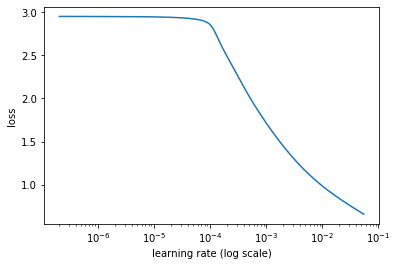

In [7]:
learner.lr_find(max_epochs=3, show_plot=True)

In [7]:
learner.autofit(0.01)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 43163 samples, validate on 4796 samples
Epoch 1/1024
43163/43163 [==============================] - 45s 1ms/step - loss: 0.3819 - crf_accuracy: 0.9115 - val_loss: 0.0618 - val_crf_accuracy: 0.9833
Epoch 2/1024
43163/43163 [==============================] - 41s 958us/step - loss: 0.0454 - crf_accuracy: 0.9871 - val_loss: 0.0366 - val_crf_accuracy: 0.9892
Epoch 3/1024
43163/43163 [==============================] - 41s 949us/step - loss: 0.0288 - crf_accuracy: 0.9912 - val_loss: 0.0307 - val_crf_accuracy: 0.9906
Epoch 4/1024
43163/43163 [==============================] - 41s 956us/step - loss: 0.0223 - crf_accuracy: 0.9927 - val_loss: 0.0282 - val_crf_accuracy: 0.9907
Epoch 5/1024
43163/43163 [==============================] - 41s 947us/step - loss: 0.0178 - crf_accuracy: 0.9937 - val_loss: 0.0262 - 

In [8]:
learner.validate(class_names=preproc.get_classes())

           precision    recall  f1-score   support

      gpe       0.97      0.94      0.95      1613
      art       0.36      0.13      0.19        39
      geo       0.84      0.87      0.85      3831
      tim       0.87      0.85      0.86      2030
      org       0.71      0.66      0.69      1972
      per       0.76      0.70      0.73      1720
      eve       0.47      0.42      0.44        33
      nat       0.44      0.50      0.47        16

micro avg       0.83      0.81      0.82     11254
macro avg       0.83      0.81      0.82     11254



In [9]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [11]:
predictor.predict('As of 2019, Donald Trump is still the President of the United States.')

[('As', 'O'),
 ('of', 'O'),
 ('2019', 'B-tim'),
 (',', 'O'),
 ('Donald', 'B-per'),
 ('Trump', 'I-per'),
 ('is', 'O'),
 ('still', 'O'),
 ('the', 'O'),
 ('President', 'B-per'),
 ('of', 'O'),
 ('the', 'O'),
 ('United', 'B-geo'),
 ('States', 'I-geo'),
 ('.', 'O')]

In [12]:
example = preproc.undo_val(val, val_id=0)

In [13]:
example

[('They', 'O'),
 ('say', 'O'),
 ('the', 'O'),
 ('woman', 'O'),
 ('was', 'O'),
 ('from', 'O'),
 ('Tangerang', 'B-geo'),
 (',', 'O'),
 ('a', 'O'),
 ('city', 'O'),
 ('outside', 'O'),
 ('of', 'O'),
 ('Jakarta', 'B-geo'),
 (',', 'O'),
 ('and', 'O'),
 ('that', 'O'),
 ('she', 'O'),
 ('lived', 'O'),
 ('in', 'O'),
 ('a', 'O'),
 ('neighborhood', 'O'),
 ('with', 'O'),
 ('backyard', 'O'),
 ('farms', 'O'),
 ('and', 'O'),
 ('near', 'O'),
 ('a', 'O'),
 ('traditional', 'O'),
 ('market', 'O'),
 ('that', 'O'),
 ('sells', 'O'),
 ('poultry', 'O'),
 ('.', 'O')]

In [14]:
predictor.predict(" ".join([x[0] for x in example]))

[('They', 'O'),
 ('say', 'O'),
 ('the', 'O'),
 ('woman', 'O'),
 ('was', 'O'),
 ('from', 'O'),
 ('Tangerang', 'B-geo'),
 (',', 'O'),
 ('a', 'O'),
 ('city', 'O'),
 ('outside', 'O'),
 ('of', 'O'),
 ('Jakarta', 'B-geo'),
 (',', 'O'),
 ('and', 'O'),
 ('that', 'O'),
 ('she', 'O'),
 ('lived', 'O'),
 ('in', 'O'),
 ('a', 'O'),
 ('neighborhood', 'O'),
 ('with', 'O'),
 ('backyard', 'O'),
 ('farms', 'O'),
 ('and', 'O'),
 ('near', 'O'),
 ('a', 'O'),
 ('traditional', 'O'),
 ('market', 'O'),
 ('that', 'O'),
 ('sells', 'O'),
 ('poultry', 'O'),
 ('.', 'O')]

In [15]:
predictor.save('/tmp/mypred')

In [16]:
reloaded_predictor = ktrain.load_predictor('/tmp/mypred')

In [17]:
reloaded_predictor.predict('Paul Newman is my favorite American actor.')

[('Paul', 'B-per'),
 ('Newman', 'I-per'),
 ('is', 'O'),
 ('my', 'O'),
 ('favorite', 'O'),
 ('American', 'B-gpe'),
 ('actor', 'O'),
 ('.', 'O')]